In [1]:
%reset -f

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.special import hermite
import os

In [4]:
# Set deterministic behavior for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.set_num_threads(1)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 1)
        )

    def forward(self, q, n, omega):
        x = torch.cat((q, n, omega), dim=1)
        return self.net(x)

In [7]:
from math import factorial, pi

def true_wavefunction(q, n, omega):
    q = q.view(-1)
    Hn = hermite(n)
    coeff = (omega / pi) ** 0.25 / (2 ** n * factorial(n)) ** 0.5
    psi = coeff * torch.tensor(Hn(np.sqrt(omega) * q.cpu().numpy()), dtype=torch.float32) * torch.exp(-0.5 * omega * q ** 2)
    return psi.view(-1, 1).to(device)

In [8]:
# Build dataset
def build_training_dataset(train_ns, omegas, q_vals):
    q_list, n_list, omega_list, psi_list = [], [], [], []
    for n in train_ns:
        for omega in omegas:
            q_list.append(q_vals)
            n_list.append(torch.full_like(q_vals, float(n)))
            omega_list.append(torch.full_like(q_vals, float(omega)))
            psi_list.append(true_wavefunction(q_vals, n, omega))
    return torch.cat(q_list), torch.cat(n_list), torch.cat(omega_list), torch.cat(psi_list)

In [9]:
def mse_loss(model, q, n, omega, psi_true):
    pred = model(q, n, omega)
    return torch.mean((pred - psi_true) ** 2)

def physics_loss(model, q, n, omega):
    q.requires_grad_(True)
    psi = model(q, n, omega)
    dpsi_dq = torch.autograd.grad(psi, q, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
    d2psi_dq2 = torch.autograd.grad(dpsi_dq, q, grad_outputs=torch.ones_like(dpsi_dq), create_graph=True)[0]
    V = 0.5 * (omega ** 2) * (q ** 2)
    E = omega * (n + 0.5)
    schrodinger = -0.5 * d2psi_dq2 + V * psi - E * psi
    return torch.mean(schrodinger ** 2)

def boundary_loss(model, q_b, n, omega):
    pred = model(q_b, n, omega)
    return torch.mean(pred ** 2)

def normalization_loss(model, q_vals, train_ns, omegas):
    loss = 0
    for n in train_ns:
        for omega in omegas:
            q = q_vals
            n_tensor = torch.full_like(q, float(n))
            omega_tensor = torch.full_like(q, float(omega))
            psi = model(q, n_tensor, omega_tensor)
            integral = torch.trapz(psi.squeeze() ** 2, q.squeeze())
            loss += (integral - 1.0) ** 2
    return loss / (len(train_ns) * len(omegas))

In [10]:
# Evaluate model on test data
def evaluate_model_on_data(model, q_vals, ns, omegas):
    model.eval()
    with torch.no_grad():
        for n in ns:
            for omega in omegas:
                q = q_vals
                n_tensor = torch.full_like(q, float(n))
                omega_tensor = torch.full_like(q, float(omega))
                psi_pred = model(q, n_tensor, omega_tensor).squeeze()
                psi_true = true_wavefunction(q, n, omega).squeeze()
                plt.plot(q.cpu().numpy(), psi_true.cpu().numpy(), label=f"True n={n}, ω={omega}")
                plt.plot(q.cpu().numpy(), psi_pred.cpu().numpy(), '--', label=f"Pred n={n}, ω={omega}")
                plt.legend(); plt.grid(); plt.title("Wavefunction Prediction vs True"); plt.show()

In [11]:
# Data and training setup
q_vals = torch.linspace(-5, 5, 256).view(-1, 1).to(device)
train_ns, test_ns = [0, 1, 3, 4, 6], [2, 5]
omegas = [round(x, 1) for x in np.arange(0.5, 1.6, 0.2)]

model = PINN().to(device)
q_batch, n_batch, omega_batch, psi_batch = build_training_dataset(train_ns, omegas, q_vals)

batch_size = 256
epochs = 80000
optimizer = optim.Adam(model.parameters(), lr=2e-3)

loss_history = []
best_loss = float('inf')
q_b = torch.tensor([[-5.0], [5.0]]).to(device)

for epoch in range(epochs + 1):
    idx = torch.randint(0, q_batch.shape[0], (batch_size,))
    qb, nb, ob, psib = q_batch[idx], n_batch[idx], omega_batch[idx], psi_batch[idx]

    optimizer.zero_grad()
    mse = mse_loss(model, qb, nb, ob, psib)

    n_sample = random.sample(train_ns, k=2)
    omega_sample = random.sample(omegas, k=2)

    phys = torch.stack([
        physics_loss(model, q_vals, torch.full_like(q_vals, float(n)), torch.full_like(q_vals, float(omega)))
        for n in n_sample for omega in omega_sample
    ]).mean()

    b_loss = torch.stack([
        boundary_loss(model, q_b, torch.full_like(q_b, float(n)), torch.full_like(q_b, float(omega)))
        for n in n_sample for omega in omega_sample
    ]).mean()

    norm_loss = normalization_loss(model, q_vals, n_sample, omega_sample)

    total_loss = mse + phys + 5 * b_loss + norm_loss
    total_loss.backward()
    optimizer.step()

    if total_loss.item() < best_loss:
        best_loss = total_loss.item()
        torch.save(model.state_dict(), "best_pinn_model.pth")

    if epoch % 500 == 0:
        loss_history.append(total_loss.item())
        print(f"Epoch {epoch} | Tot {total_loss.item():.5f} | MSE {mse.item():.5f} | Phys {phys.item():.5f} | B {b_loss.item():.5f} | Norm {norm_loss.item():.5f}")

Epoch 0 | Tot 1.10860 | MSE 0.12077 | Phys 0.05184 | B 0.02101 | Norm 0.83093
Epoch 500 | Tot 0.31918 | MSE 0.15984 | Phys 0.12295 | B 0.00005 | Norm 0.03614
Epoch 1000 | Tot 0.19478 | MSE 0.15315 | Phys 0.03574 | B 0.00022 | Norm 0.00480
Epoch 1500 | Tot 0.37084 | MSE 0.14959 | Phys 0.17894 | B 0.00017 | Norm 0.04146
Epoch 2000 | Tot 0.36434 | MSE 0.16232 | Phys 0.12224 | B 0.00047 | Norm 0.07743
Epoch 2500 | Tot 0.22081 | MSE 0.12129 | Phys 0.09021 | B 0.00015 | Norm 0.00856
Epoch 3000 | Tot 0.30751 | MSE 0.19918 | Phys 0.09562 | B 0.00039 | Norm 0.01075
Epoch 3500 | Tot 0.28268 | MSE 0.12569 | Phys 0.15007 | B 0.00044 | Norm 0.00471
Epoch 4000 | Tot 0.23067 | MSE 0.08768 | Phys 0.12596 | B 0.00006 | Norm 0.01675
Epoch 4500 | Tot 0.41135 | MSE 0.11148 | Phys 0.29465 | B 0.00002 | Norm 0.00512
Epoch 5000 | Tot 0.15754 | MSE 0.09415 | Phys 0.05056 | B 0.00003 | Norm 0.01268
Epoch 5500 | Tot 0.18190 | MSE 0.04137 | Phys 0.12866 | B 0.00042 | Norm 0.00979
Epoch 6000 | Tot 0.20527 | MSE 0

In [12]:
model.load_state_dict(torch.load("best_pinn_model.pth"))

/tmp/ipykernel_910396/1680189504.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_pinn_model.pth"))


<All keys matched successfully>


Evaluating best model on training data...


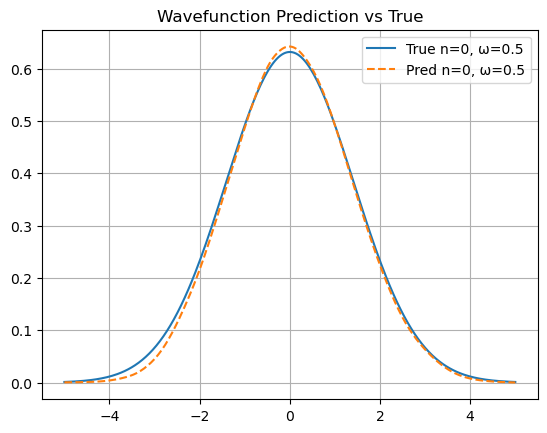

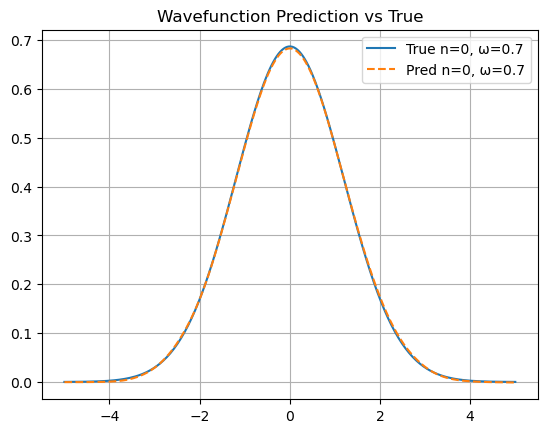

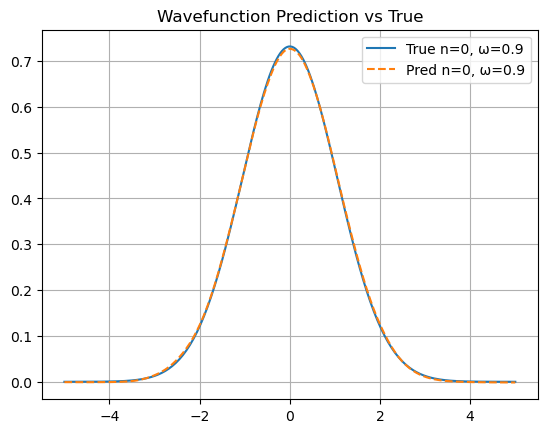

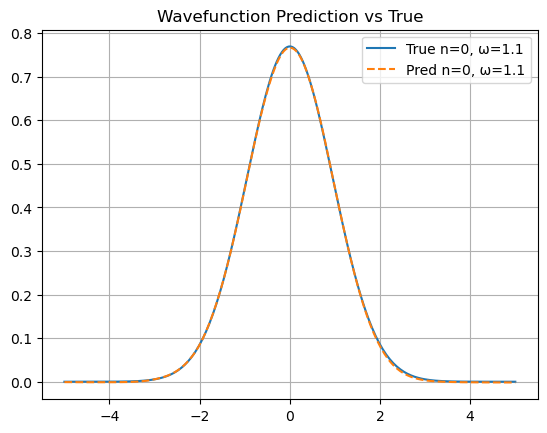

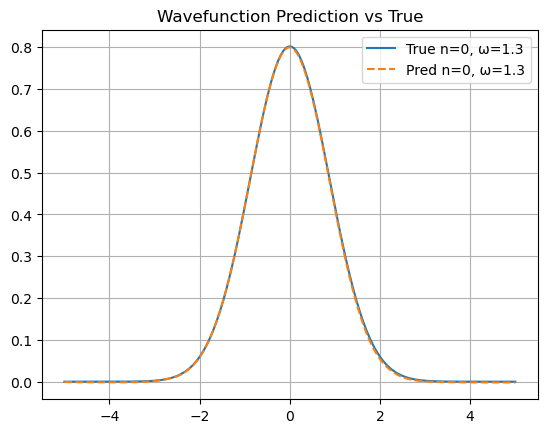

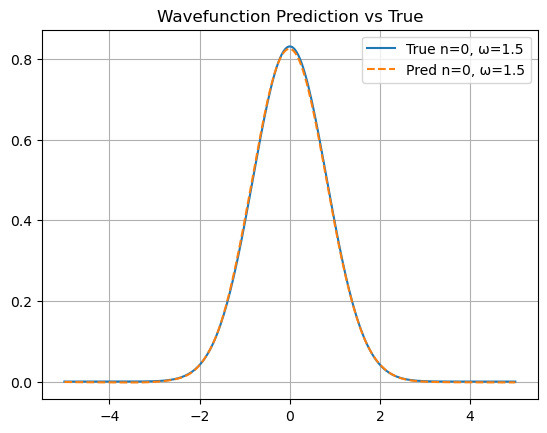

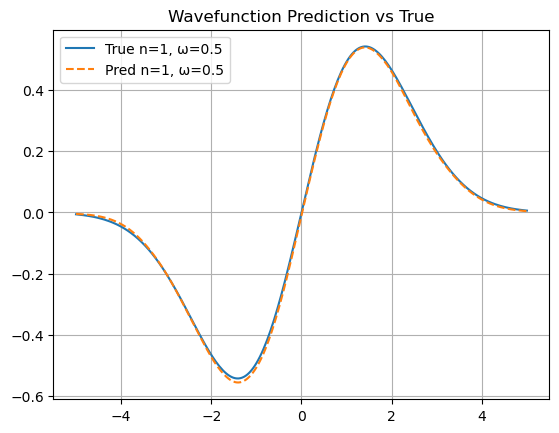

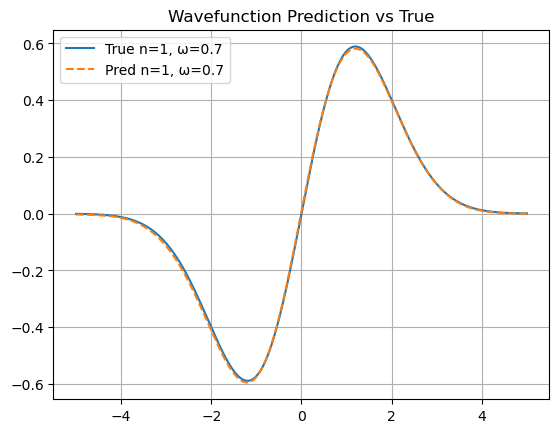

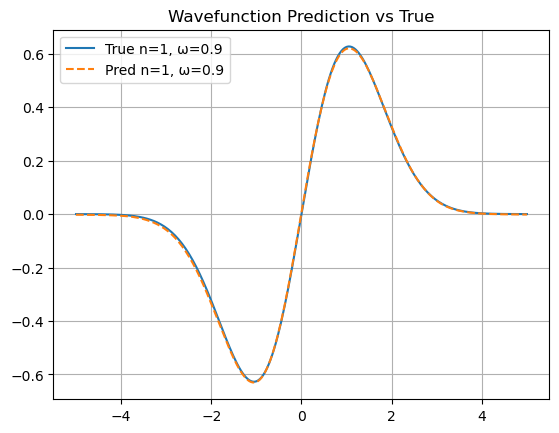

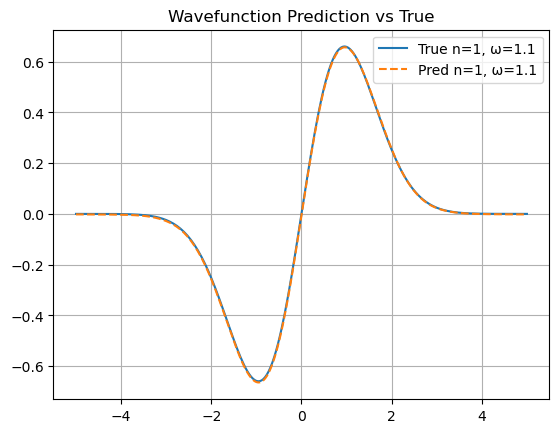

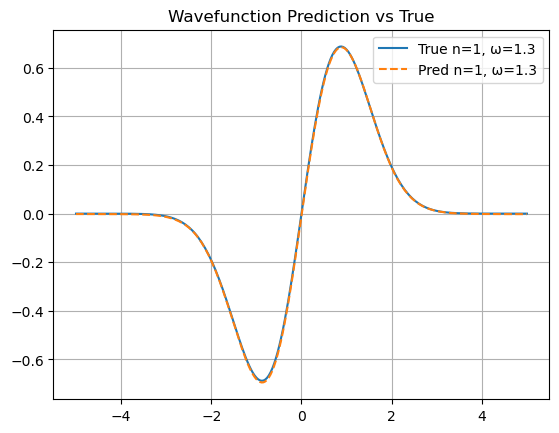

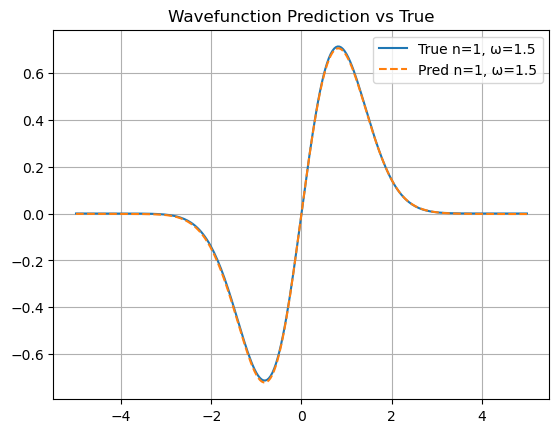

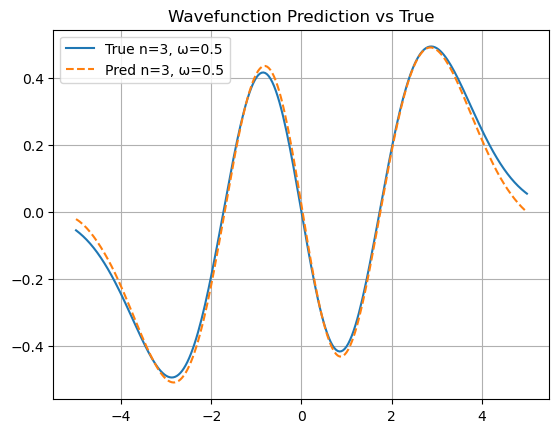

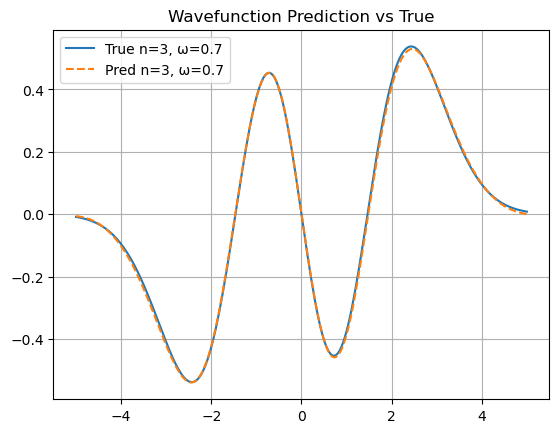

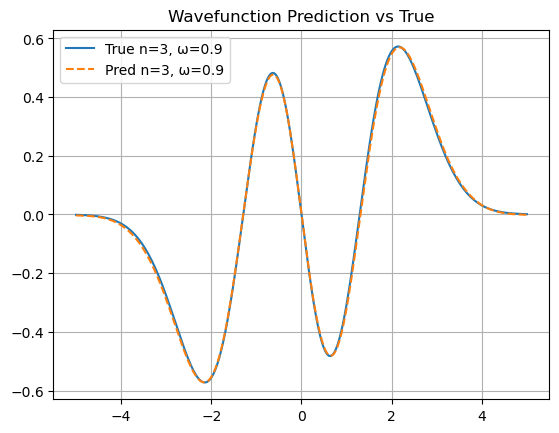

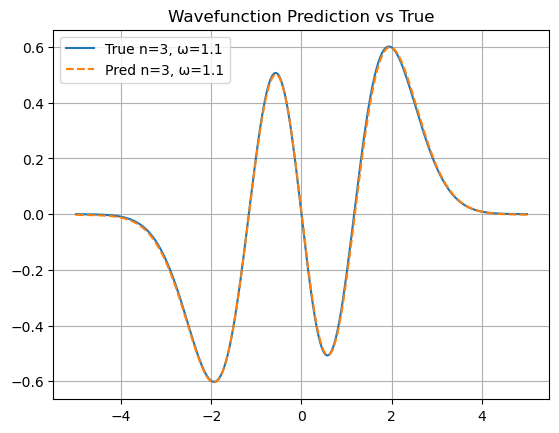

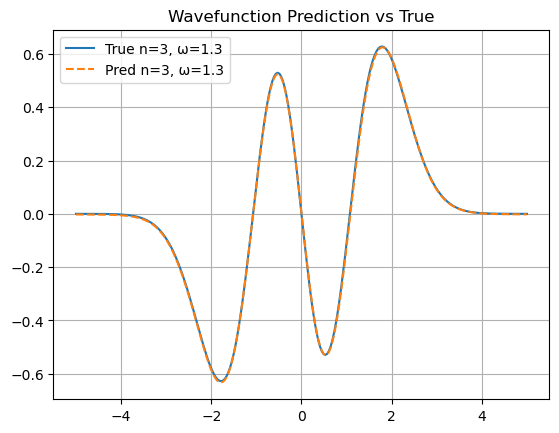

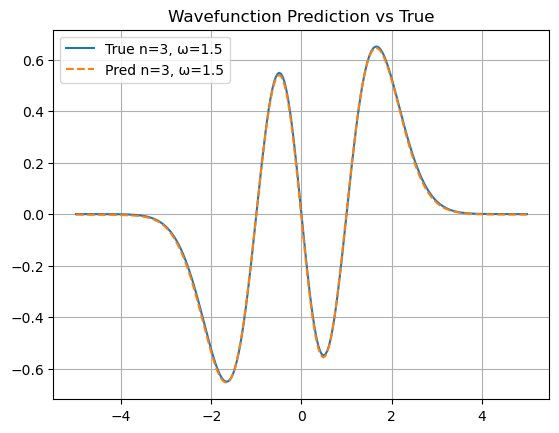

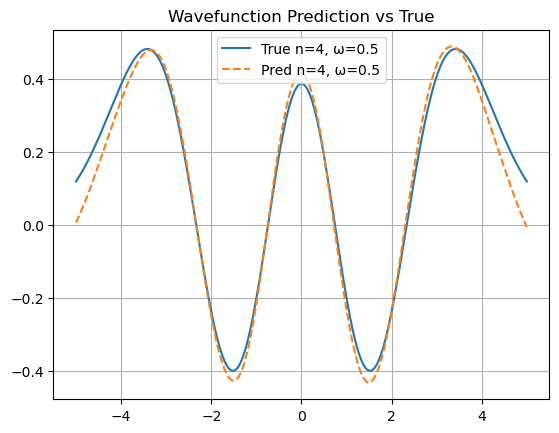

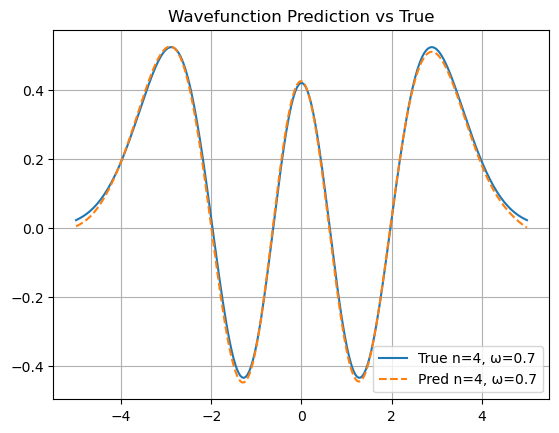

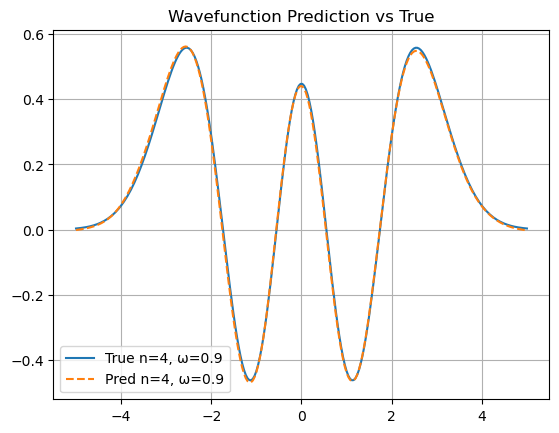

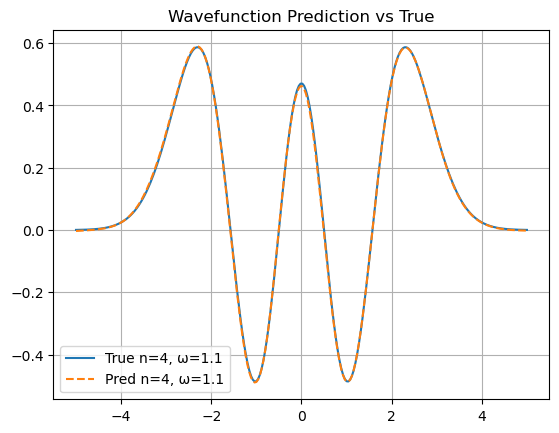

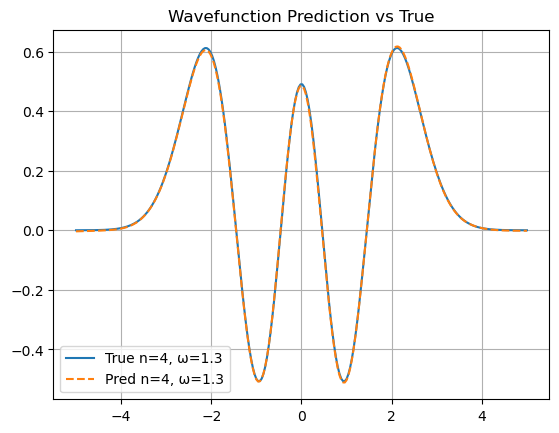

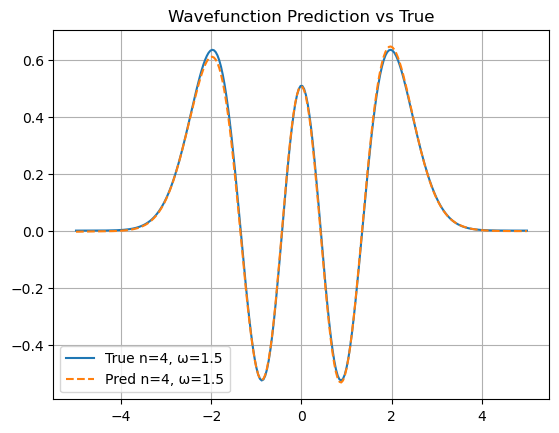

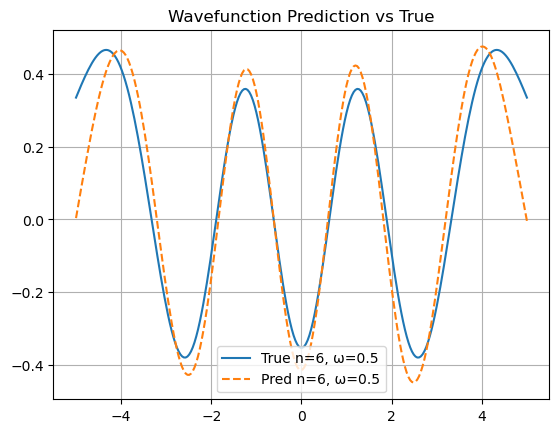

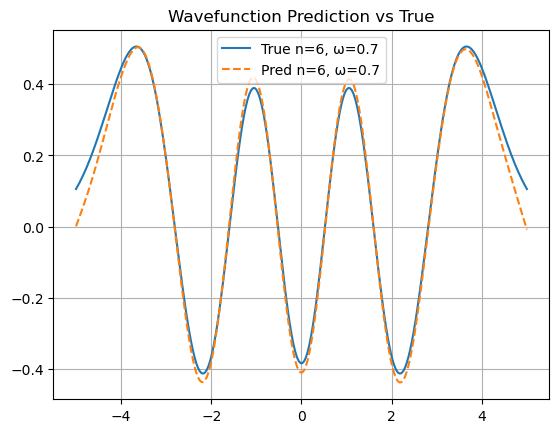

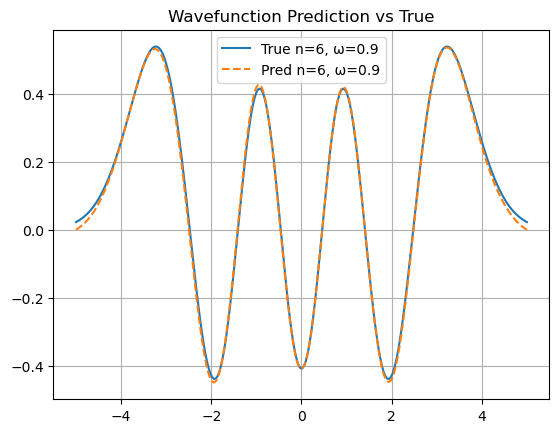

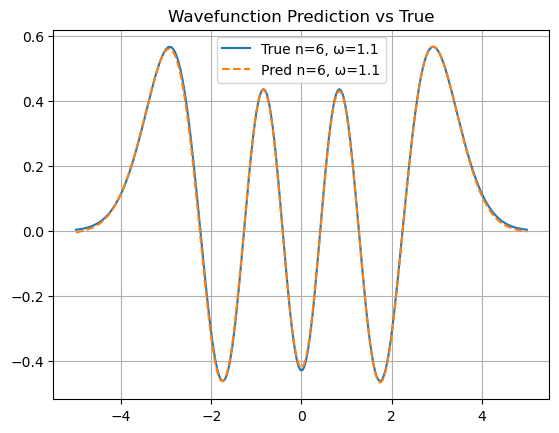

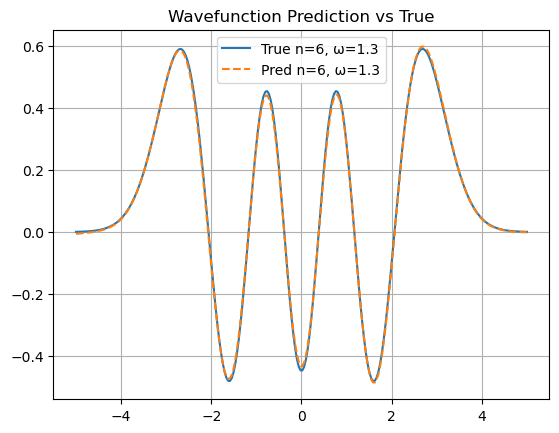

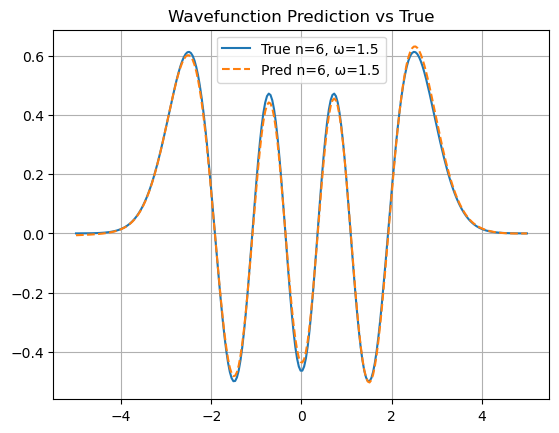

In [13]:
print("\nEvaluating best model on training data...")
evaluate_model_on_data(model, q_vals, train_ns, omegas)


Evaluating best model on test data...


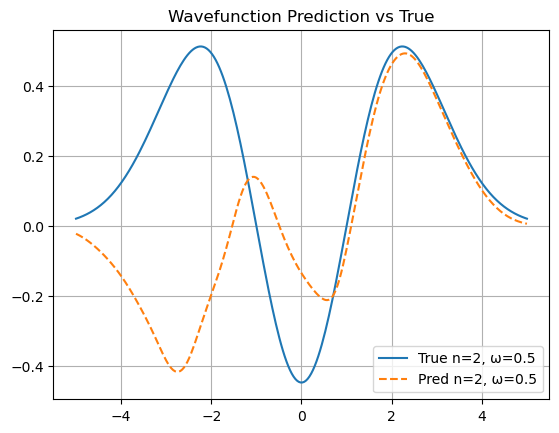

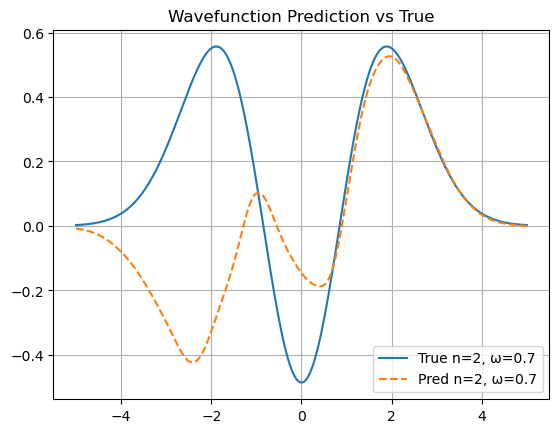

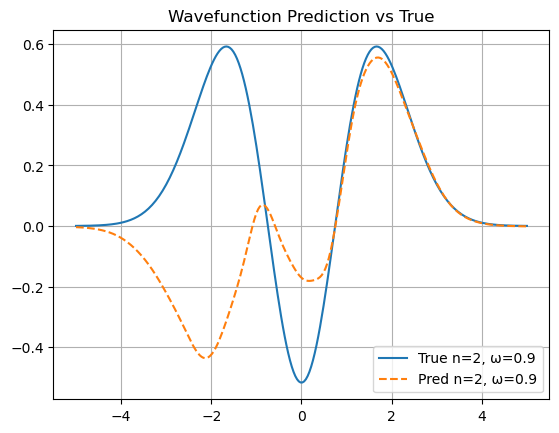

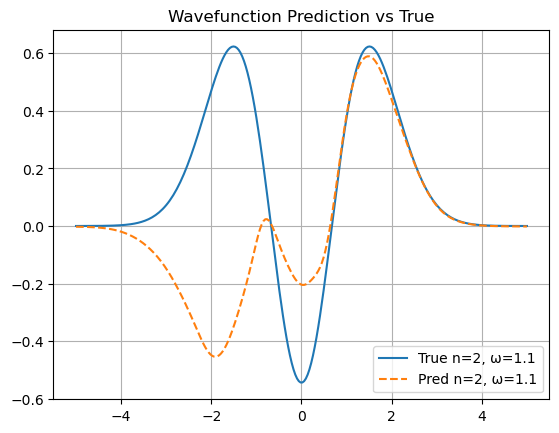

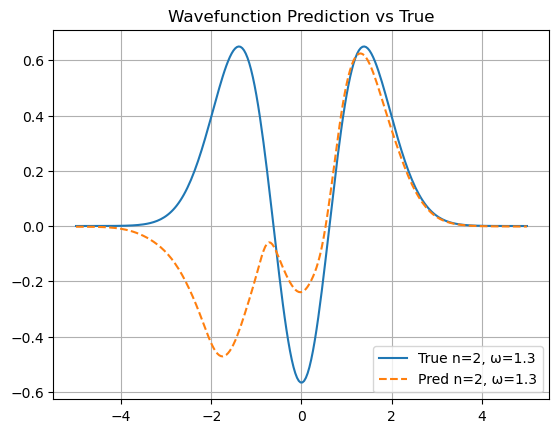

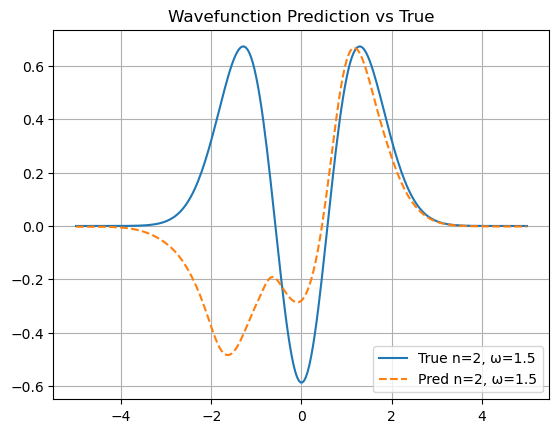

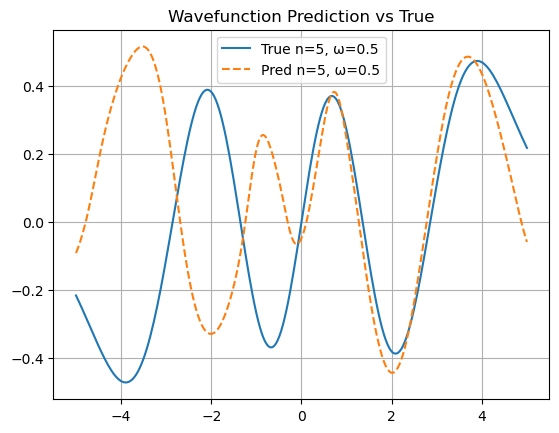

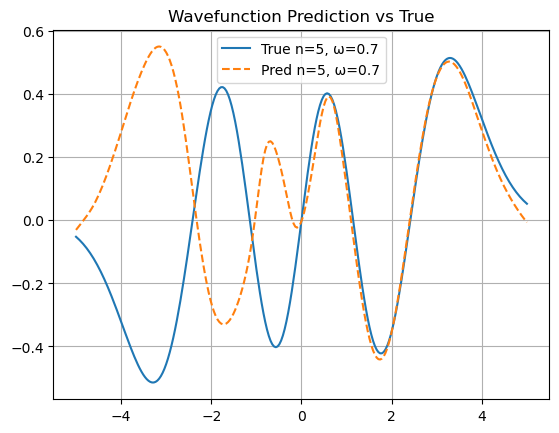

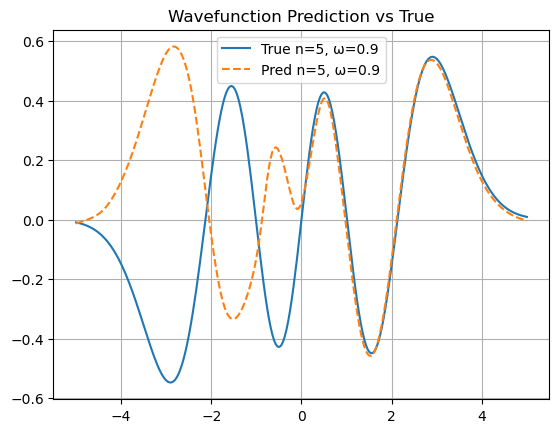

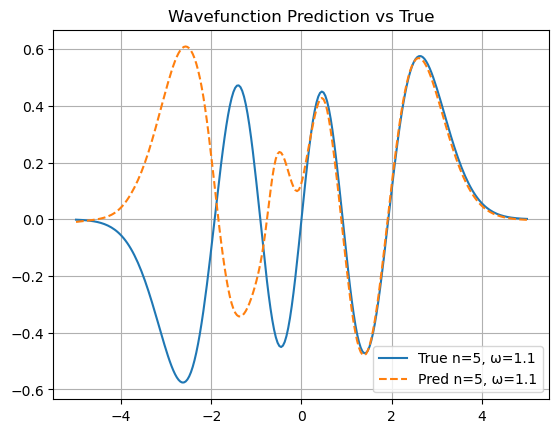

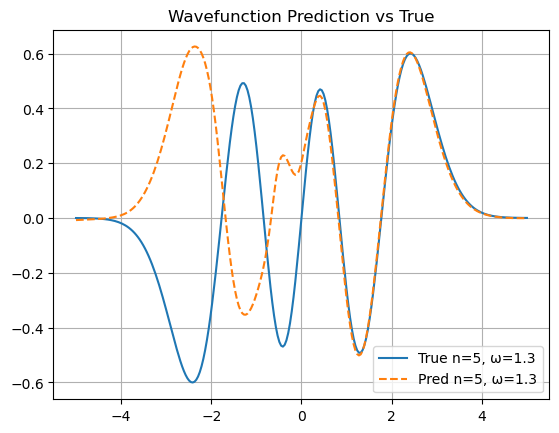

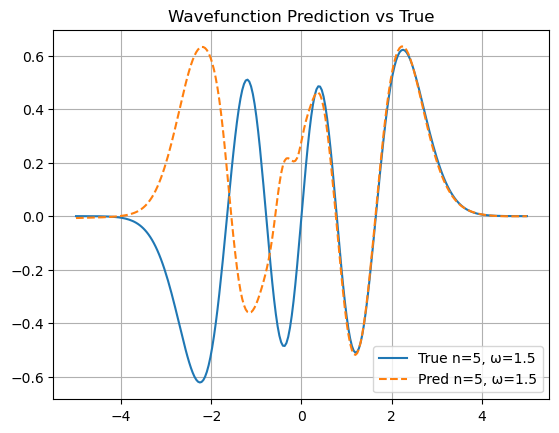

In [14]:
print("\nEvaluating best model on test data...")
evaluate_model_on_data(model, q_vals, test_ns, omegas)

In [15]:
def evaluate_model_on_data(model, q_vals, ns, omegas, save_dir="wavefunction_plots_New"):
    model.eval()
    os.makedirs(save_dir, exist_ok=True)
    
    with torch.no_grad():
        for n in ns:
            plt.figure(figsize=(10, 6))
            
            for omega in omegas:
                q = q_vals
                n_tensor = torch.full_like(q, float(n))
                omega_tensor = torch.full_like(q, float(omega))

                psi_pred = model(q, n_tensor, omega_tensor).squeeze()
                psi_true = true_wavefunction(q, n, omega).squeeze()
                
                plt.plot(q.cpu().numpy(), psi_true.cpu().numpy(), label=f"True ω={omega}, n={n}")
                plt.plot(q.cpu().numpy(), psi_pred.cpu().numpy(), '--', label=f"Pred ω={omega}, n={n}")
            
            plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
            plt.grid()
            plt.title(f"Wavefunction Prediction vs True for n={n}", fontweight='bold', pad=15, fontsize=16)
            plt.xlabel("q", fontweight='bold', fontsize=14)
            plt.ylabel("ψ(q)", fontweight='bold', fontsize=14)
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            plt.tight_layout()
            
            # Save the plot
            filename = os.path.join(save_dir, f"wavefunction_n{n}_PINN_2.png")
            plt.savefig(filename, dpi=300)
            # plt.close()

            plt.show()

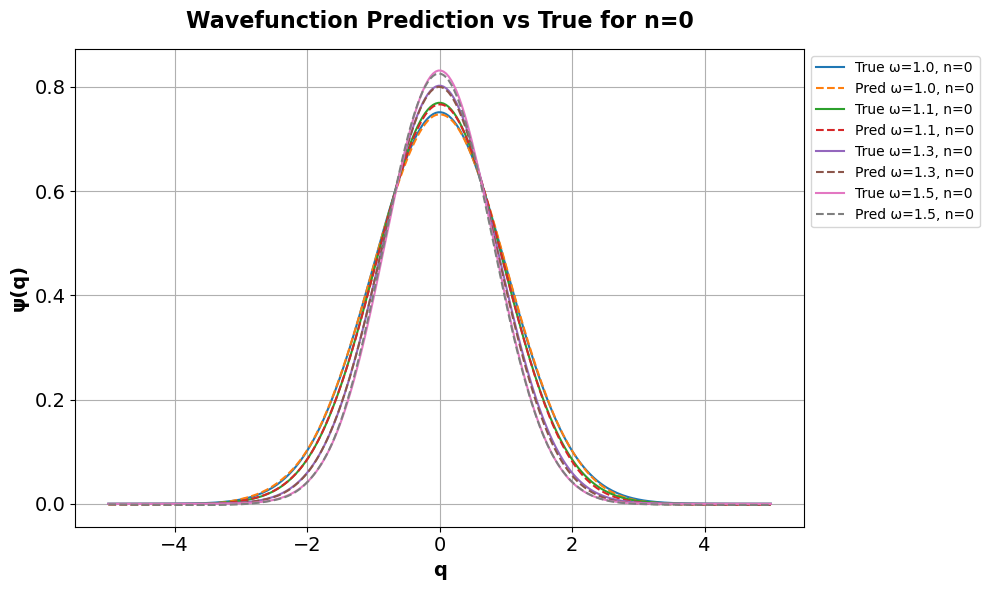

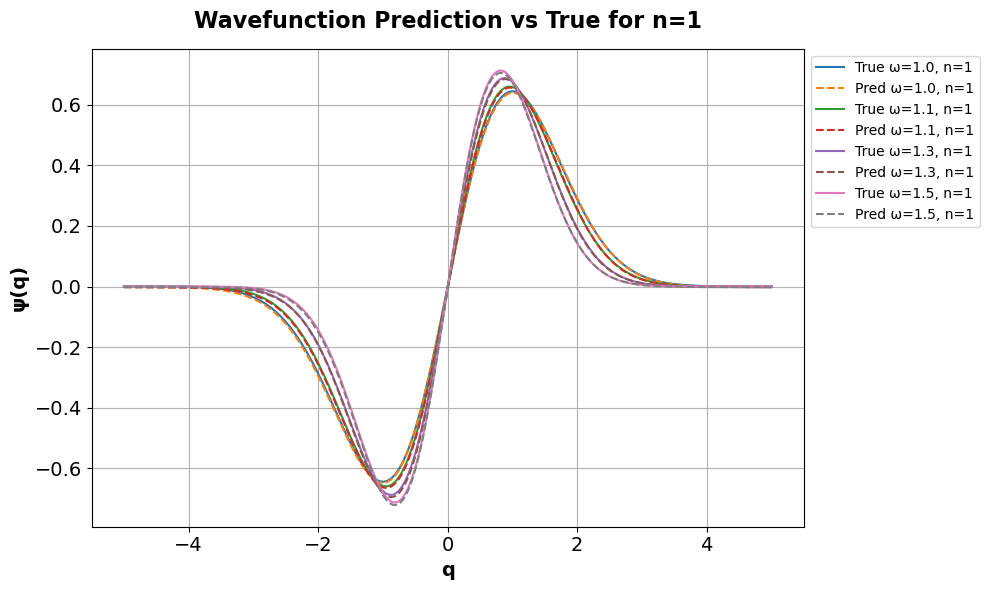

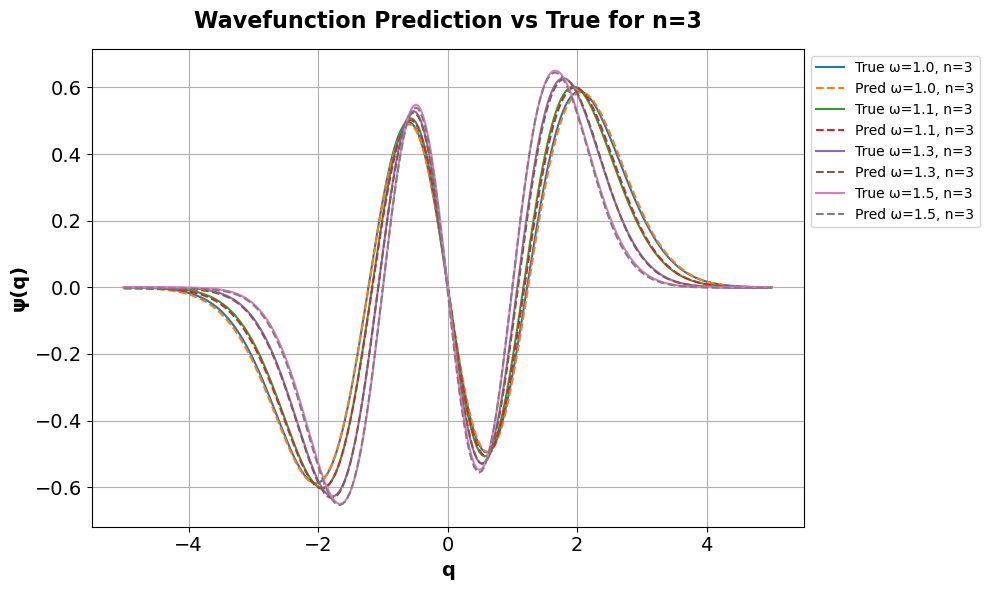

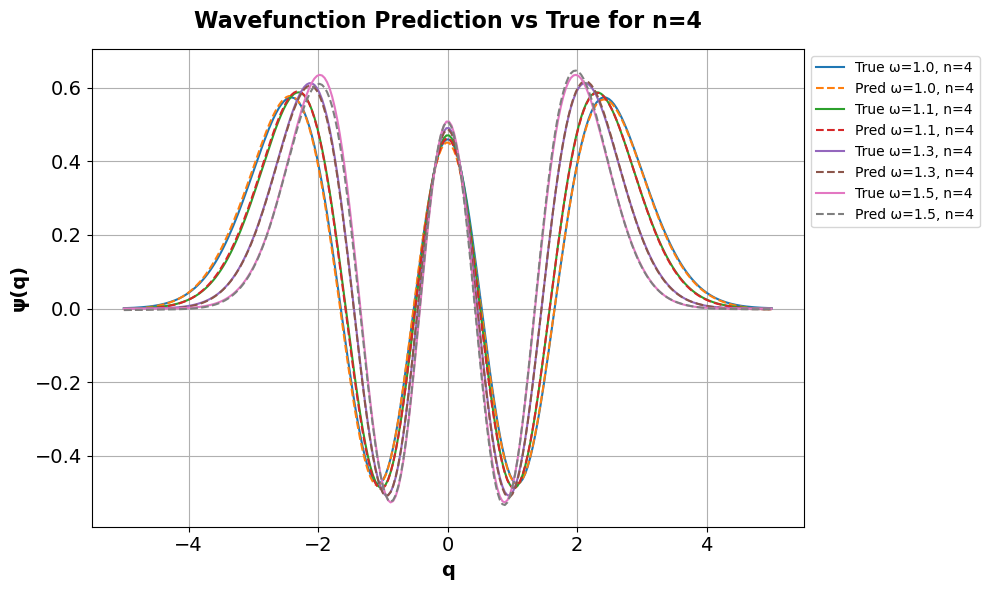

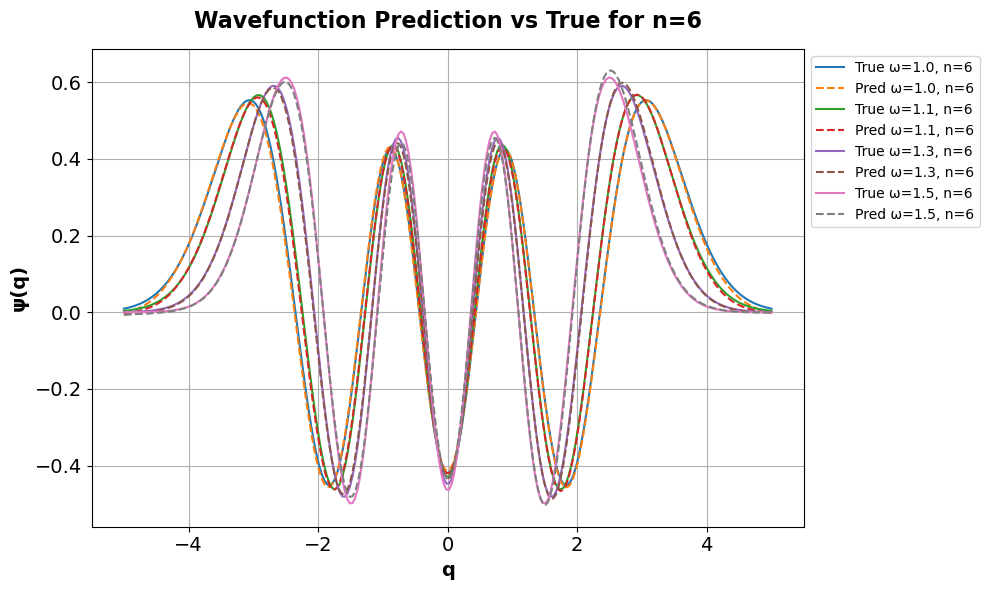

In [16]:
evaluate_model_on_data(model, q_vals, train_ns, [ 1.0, 1.1, 1.3, 1.5] )

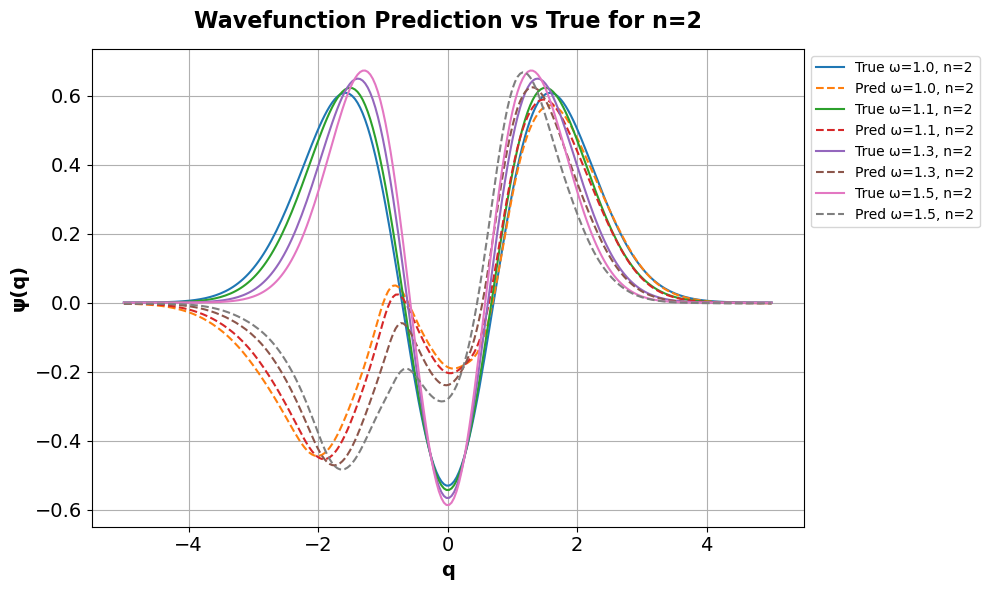

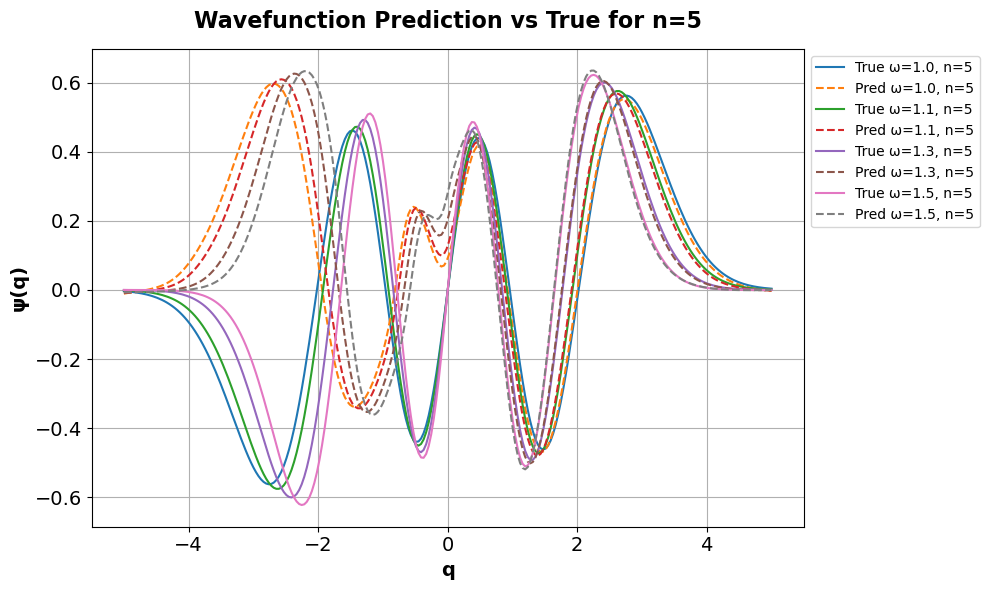

In [20]:
evaluate_model_on_data(model, q_vals, test_ns, [ 1.0, 1.1, 1.3, 1.5] )

In [22]:
def evaluate_model_on_data(model, q_vals, ns, omegas, save_dir="wavefunction_plots_PINN_2"):
    model.eval()
    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        for n in ns:
            for omega in omegas:
                q = q_vals
                n_tensor = torch.full_like(q, float(n))
                omega_tensor = torch.full_like(q, float(omega))
                
                psi_pred = model(q, n_tensor, omega_tensor).squeeze()
                psi_true = true_wavefunction(q, n, omega).squeeze()

                plt.figure(figsize=(8, 5))
                plt.plot(q.cpu().numpy(), psi_true.cpu().numpy(), label=f"True n={n}, ω={omega}", linewidth=2)
                plt.plot(q.cpu().numpy(), psi_pred.cpu().numpy(), '--', label=f"Pred n={n}, ω={omega}", linewidth=2)
                plt.xlabel("q", fontweight='bold', fontsize=12)
                plt.ylabel("ψ(q)", fontweight='bold', fontsize=12)
                plt.xticks(fontsize=12)
                plt.yticks(fontsize=12)
                plt.title(f"Wavefunction Prediction vs True (n={n}, ω={omega})", fontweight='bold', fontsize=18)
                plt.legend(fontsize=14, loc='upper right')  # Increased legend font size
                plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
                plt.tight_layout()

                filename = f"wave_n{n}_omega{omega}_New.png"
                plt.savefig(os.path.join(save_dir, filename), dpi=300, bbox_inches='tight')
                plt.show()

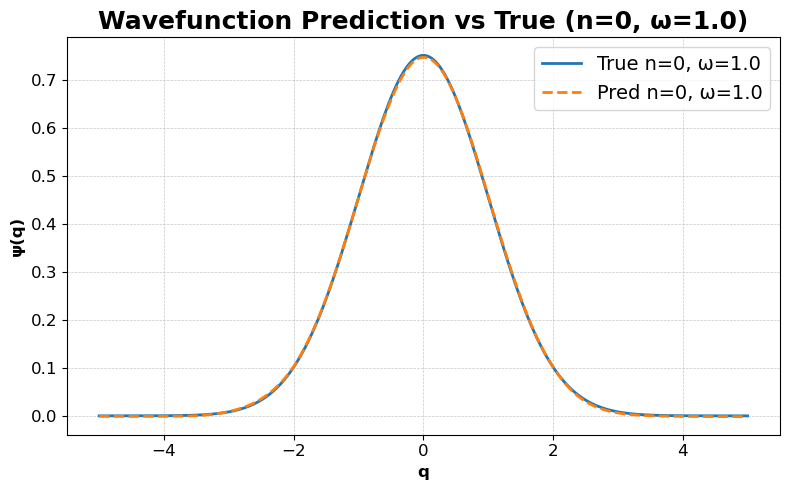

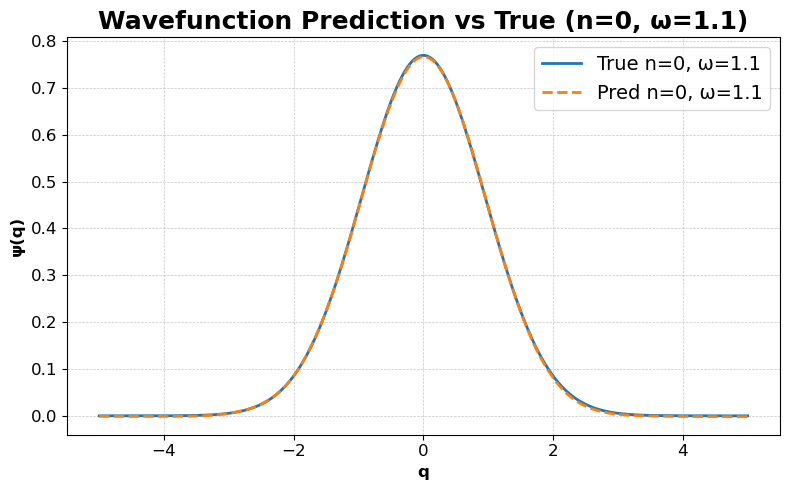

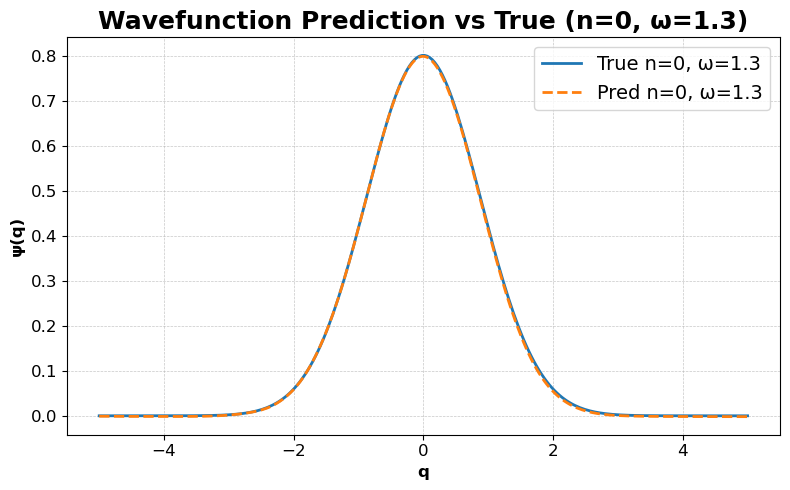

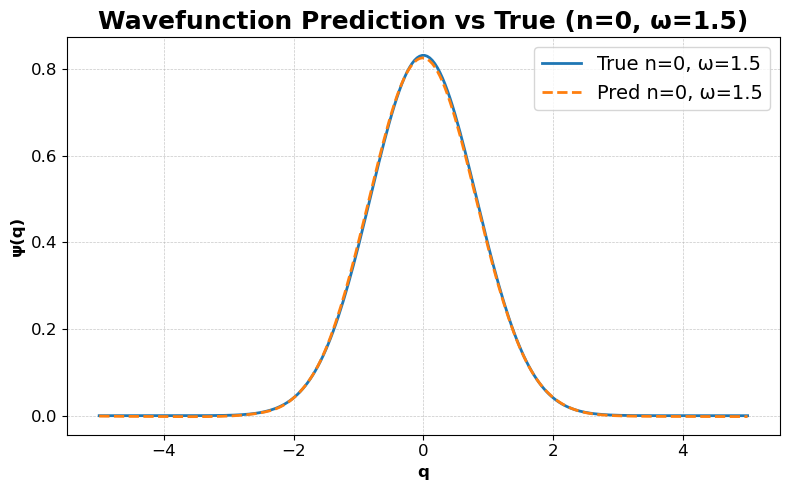

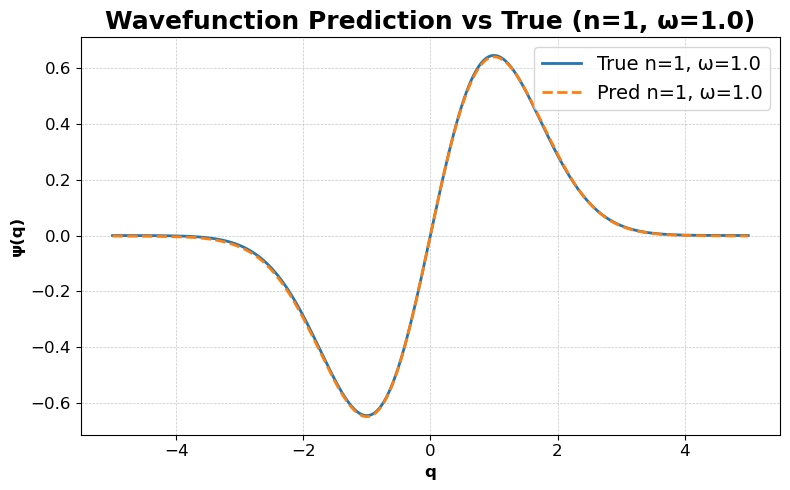

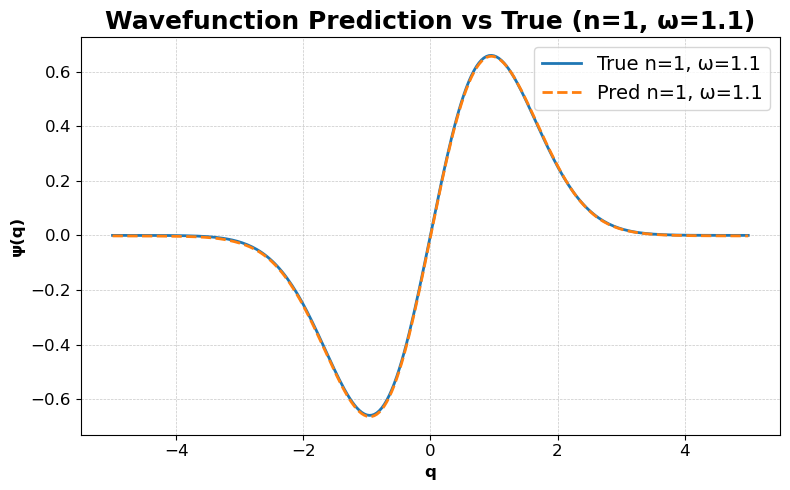

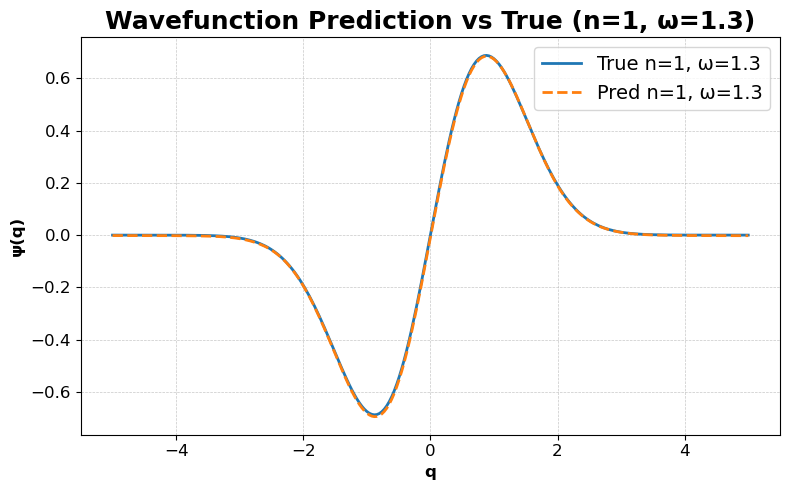

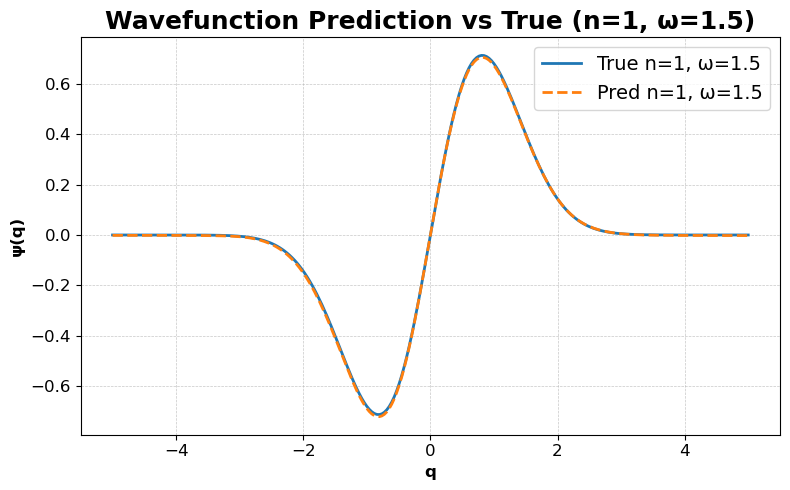

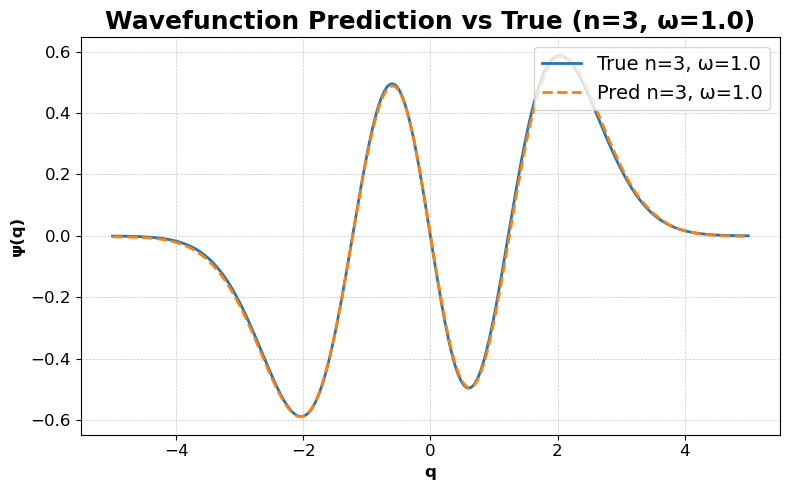

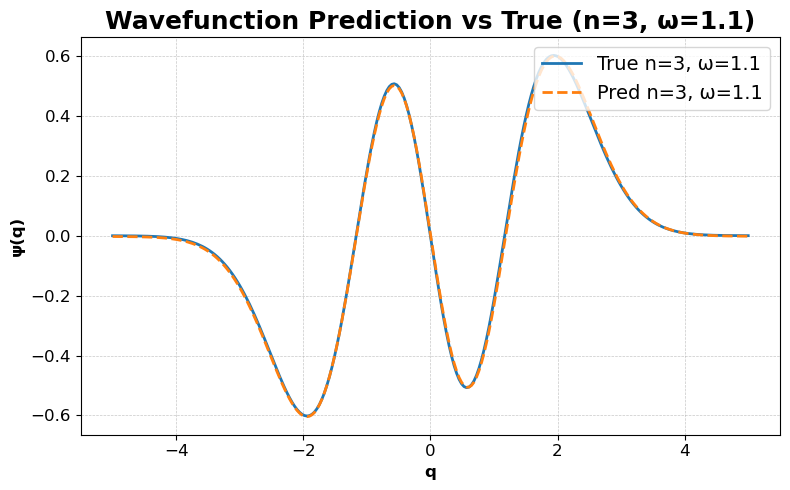

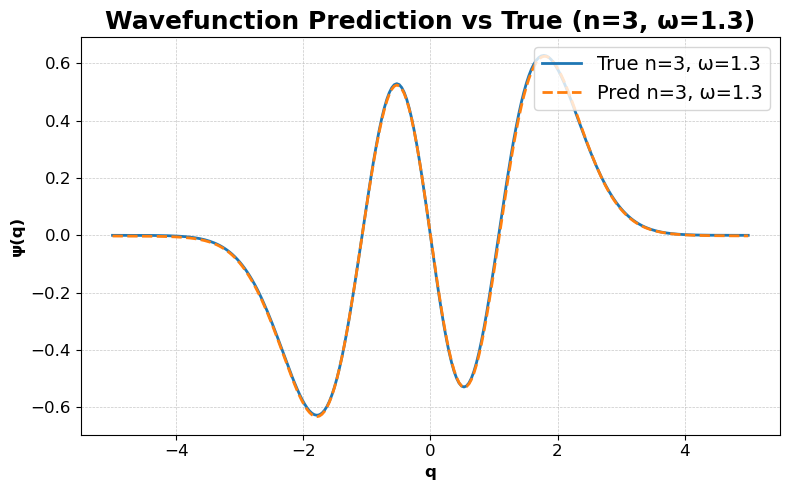

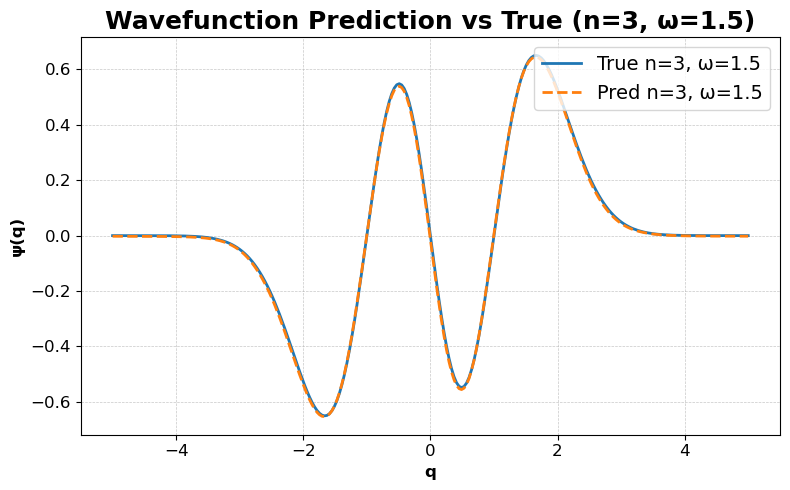

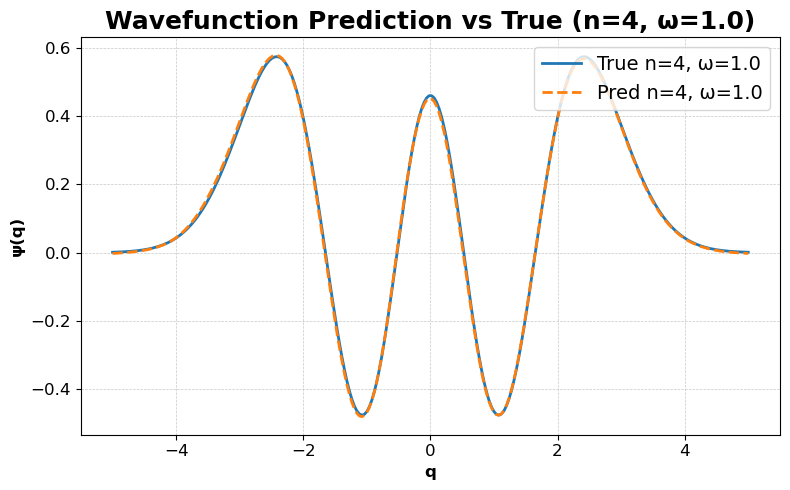

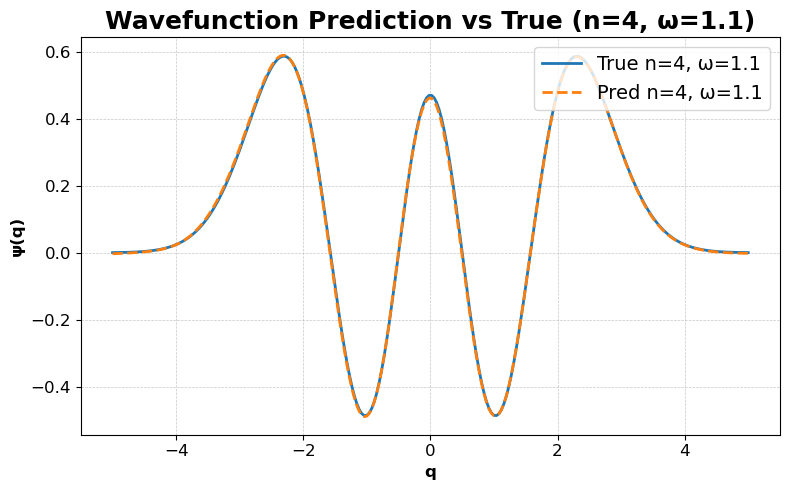

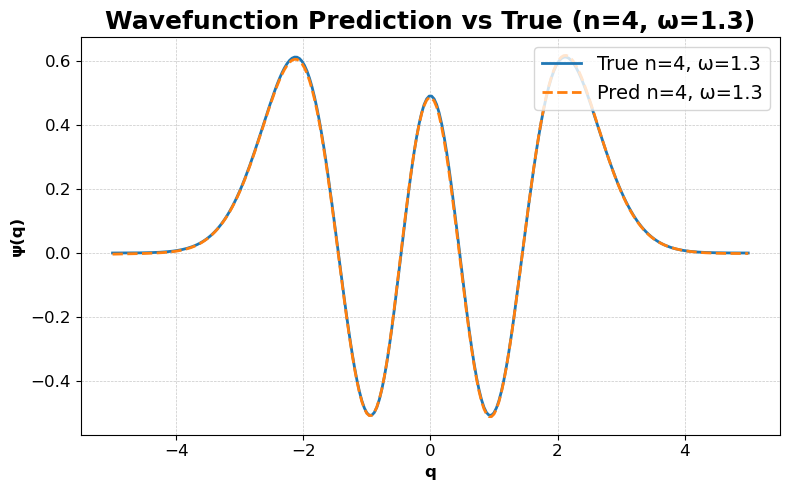

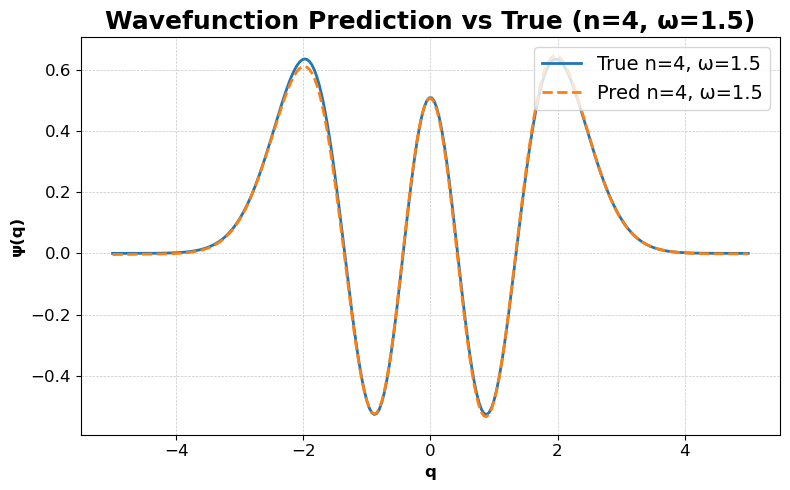

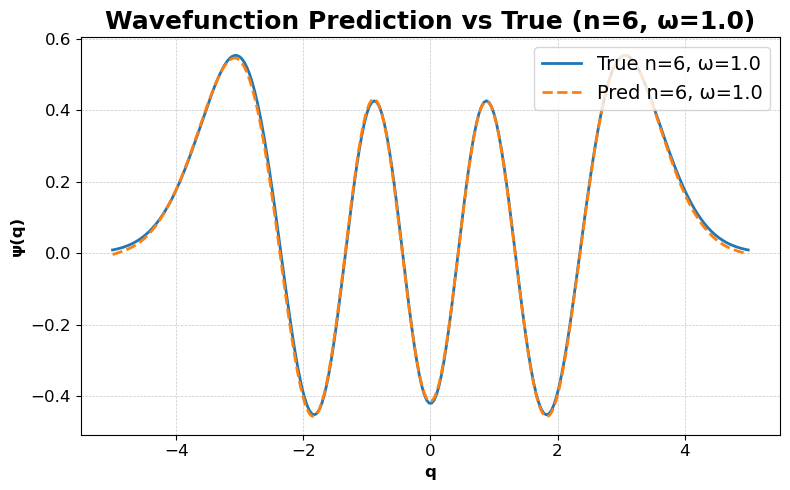

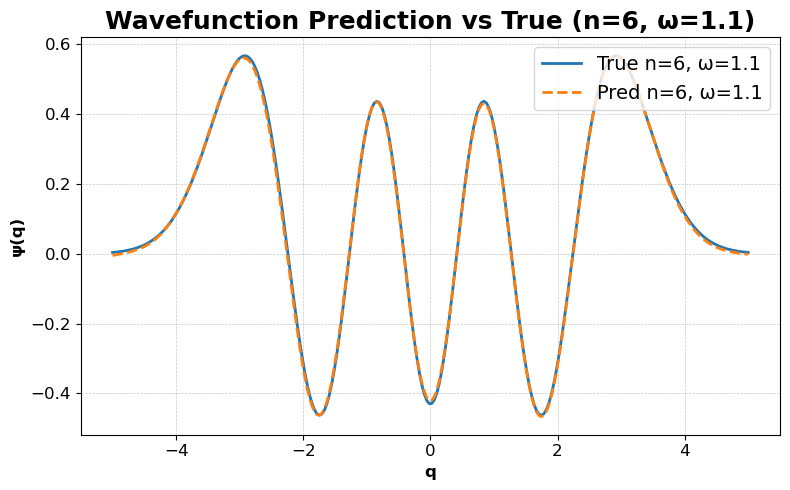

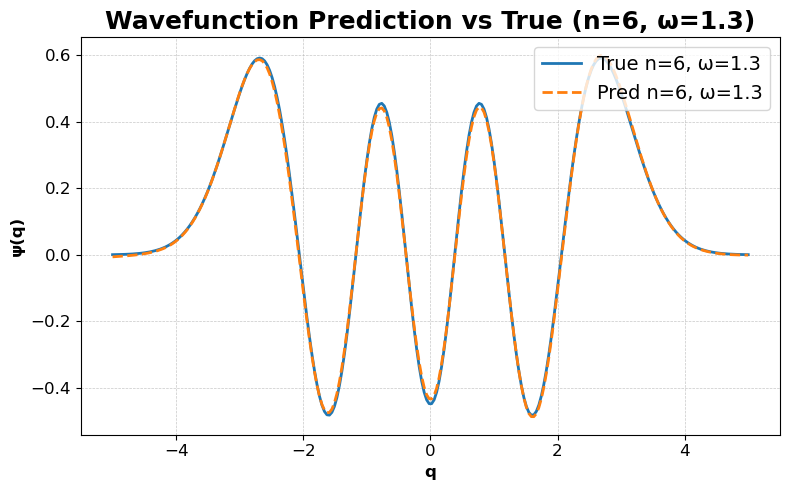

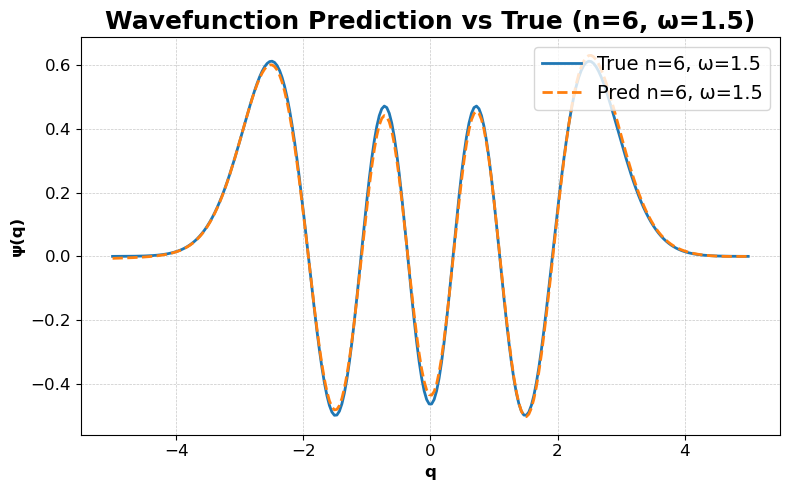

In [25]:
evaluate_model_on_data(model, q_vals, train_ns, [ 1.0, 1.1, 1.3, 1.5])

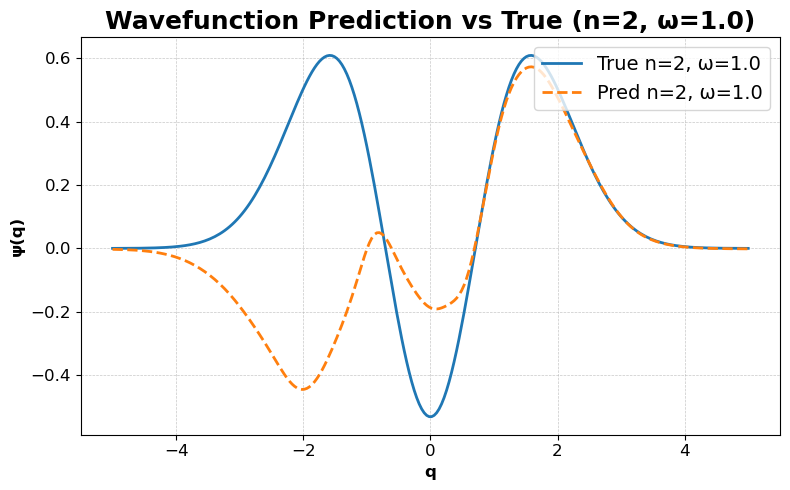

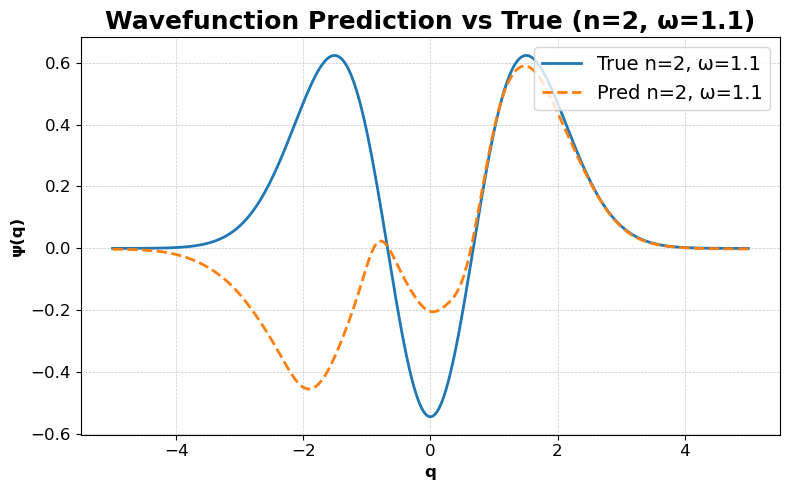

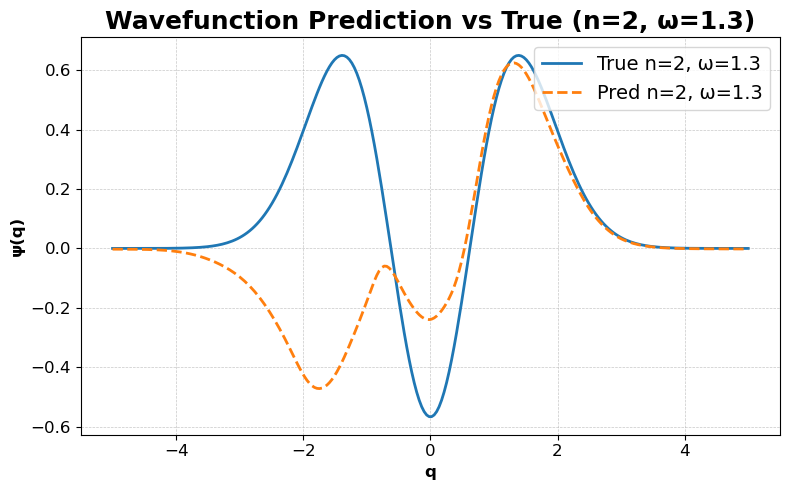

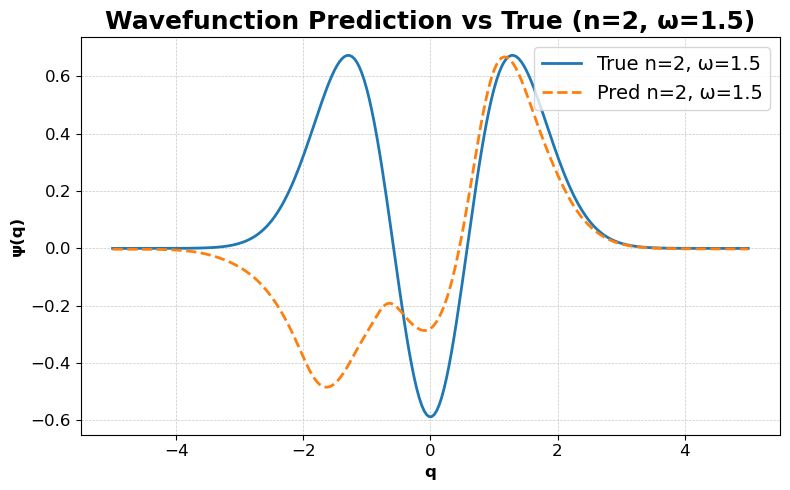

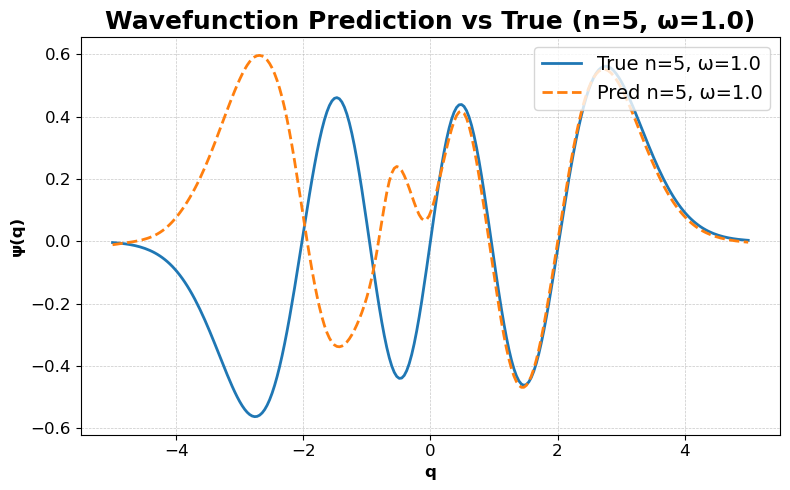

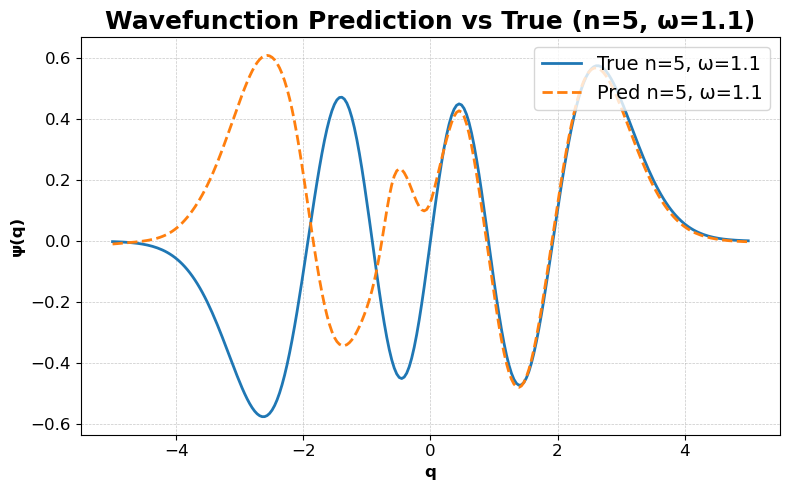

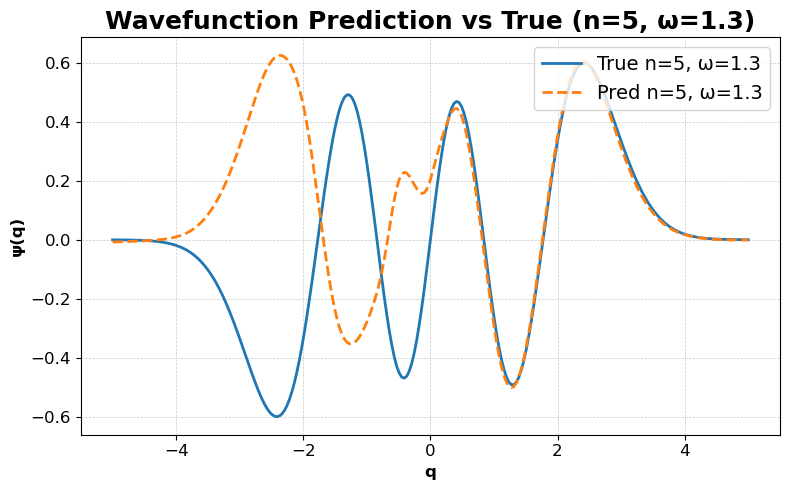

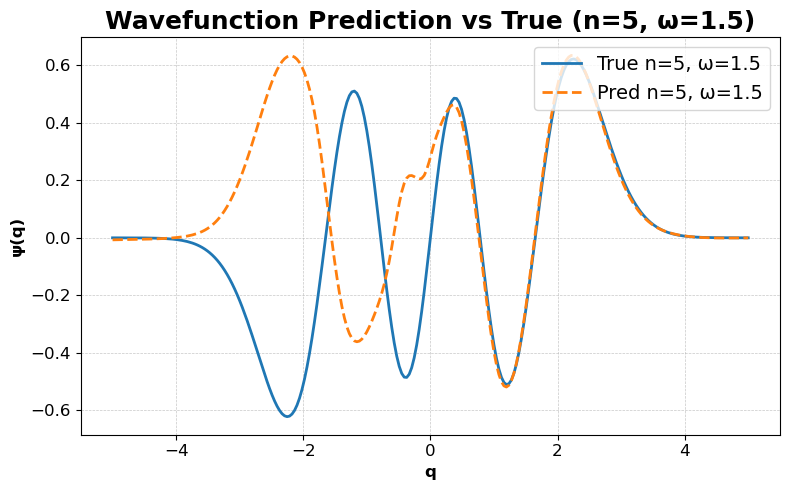

In [27]:
evaluate_model_on_data(model, q_vals, test_ns, [ 1.0, 1.1, 1.3, 1.5])